In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
# Mount google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [12]:
!wget --load-cookies /tmp/data_lab.zip "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/data_lab.zip --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MpWkHxRMgnBamD2owkOZujvm5OCQYxQS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1MpWkHxRMgnBamD2owkOZujvm5OCQYxQS" -O data_lab.zip && rm -rf /tmp/data_lab.zip

with zipfile.ZipFile('data_lab.zip', 'r') as zip_ref:
    zip_ref.extractall('data_lab')

--2020-11-11 17:15:07--  https://docs.google.com/uc?export=download&confirm=kCfn&id=1MpWkHxRMgnBamD2owkOZujvm5OCQYxQS
Resolving docs.google.com (docs.google.com)... 142.250.73.206, 2607:f8b0:4004:815::200e
Connecting to docs.google.com (docs.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-8s-docs.googleusercontent.com/docs/securesc/iv22e06ki4fmrm2fvue7qcgnqhq7fovb/hinb2b2g98sp6oplclk3mt8lqbripqkk/1605114900000/13525664275705142765/15541631209403222595Z/1MpWkHxRMgnBamD2owkOZujvm5OCQYxQS?e=download [following]
--2020-11-11 17:15:07--  https://doc-08-8s-docs.googleusercontent.com/docs/securesc/iv22e06ki4fmrm2fvue7qcgnqhq7fovb/hinb2b2g98sp6oplclk3mt8lqbripqkk/1605114900000/13525664275705142765/15541631209403222595Z/1MpWkHxRMgnBamD2owkOZujvm5OCQYxQS?e=download
Resolving doc-08-8s-docs.googleusercontent.com (doc-08-8s-docs.googleusercontent.com)... 172.217.164.161, 2607:f8b0:4004:815::2001
Connecting to doc-

In [19]:
os.listdir('/content/data_lab/data_lab')

['df_tile_lab.pkl', 'train', 'test', 'valid']

In [20]:
path_data = '/content/data_lab/data_lab'

train_dir = os.path.join(path_data, 'train')
validation_dir = os.path.join(path_data, 'valid')

BATCH_SIZE = 32
IMG_SIZE = (598, 598)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 27595 files belonging to 2 classes.


In [21]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 9115 files belonging to 2 classes.


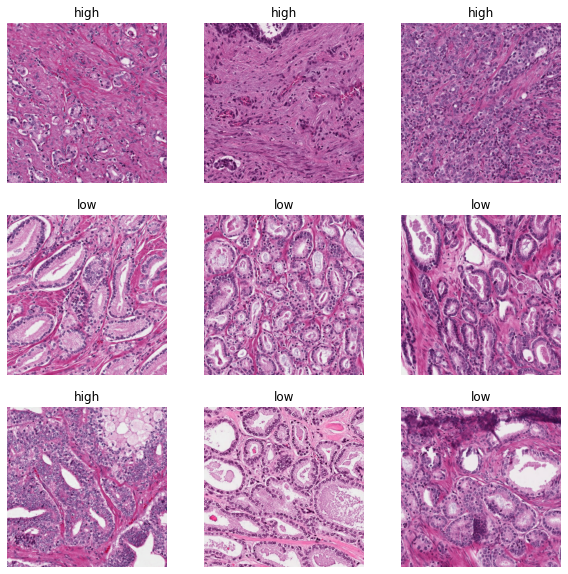

In [23]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [25]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 228
Number of test batches: 57


In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [27]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

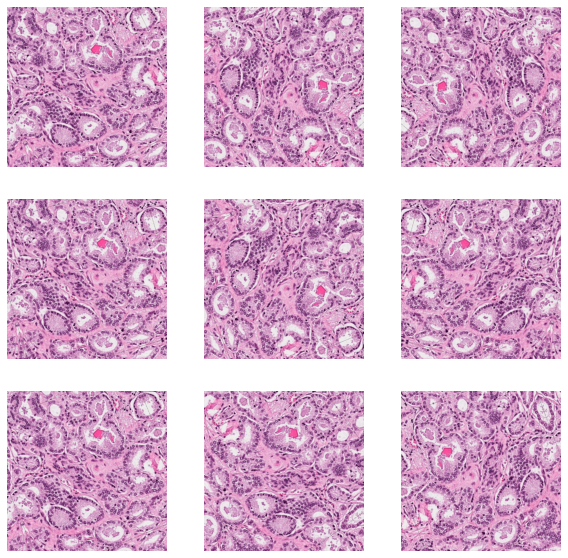

In [28]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [30]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [31]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

9412608/9406464 [==============================] - 0s 0us/step


In [41]:
inputs = tf.keras.Input(shape=(598, 598, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [42]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [43]:
base_learning_rate = 0.0001

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 598, 598, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf_op_layer_RealDiv_3 (Tenso [(None, 598, 598, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_3 (TensorFlo [(None, 598, 598, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 19, 19, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)             

In [46]:
epochs = 5

history = model.fit(train_dataset,
                    steps_per_epoch=25, 
                    validation_steps=10,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/5
25/25 [==============================] - 28s 1s/step - loss: 0.4055 - accuracy: 0.7862 - val_loss: 0.4215 - val_accuracy: 0.8125
Epoch 2/5
25/25 [==============================] - 27s 1s/step - loss: 0.4150 - accuracy: 0.7763 - val_loss: 0.3827 - val_accuracy: 0.8281
Epoch 3/5
25/25 [==============================] - 27s 1s/step - loss: 0.3995 - accuracy: 0.7950 - val_loss: 0.3661 - val_accuracy: 0.7688
Epoch 4/5
25/25 [==============================] - 27s 1s/step - loss: 0.3992 - accuracy: 0.7887 - val_loss: 0.3834 - val_accuracy: 0.7688
Epoch 5/5
25/25 [==============================] - 27s 1s/step - loss: 0.4198 - accuracy: 0.7750 - val_loss: 0.3342 - val_accuracy: 0.8500


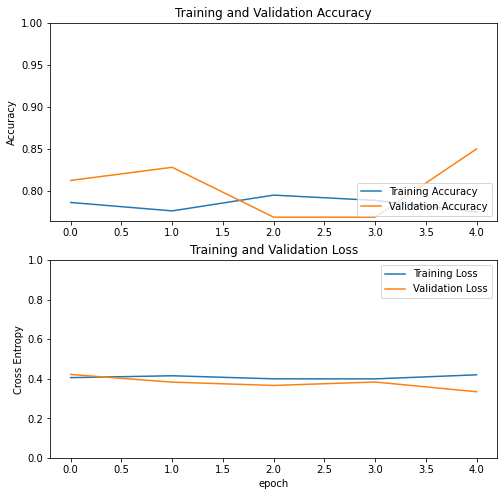

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0]
Labels:
 [0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0]


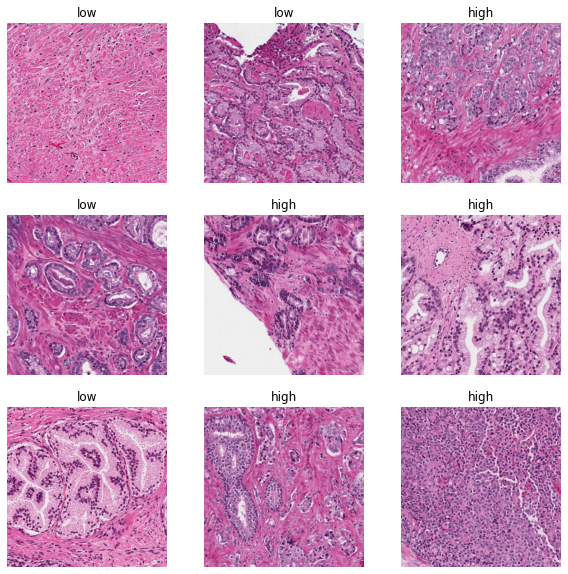

In [48]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)